# 这个damo使用网络从有限的频率中预训练，之后学习不同频率的的正弦函数
1、`reserior`: 包含了基础网络，网络中包含网络中的参数，以及对RLS的实例化

2、`rls`: 包含了FORCE算法的实现

3、`settings`: 包含了一些全局的设定

In [1]:
from settings import *
import os
import sys
sys.path.append(snnpy)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from reserior import rnn
from rls import RLS

# 基础的参数设定

In [3]:
N = 500             # Size of the reservoir
# 信号和环境的数量
N_z = 1             # Number of signals
N_c = 1             # Number of contexts
# 训练时长
t_wlearn = 5_000    # Total pretraining time(30_000 or 50_000)
t_stay = 500        # 每个训练目标切换的时间(==model.t_stay)
t_learn = 50        # Dynamical learning time(50-200)
t_test = 1_000      # Testing time

# 产生学习目标数据

In [4]:
class targets:
    def __init__(self, time_total, time_per_target, targets_list):
        '''
            time_total      : 产生数据总时长
            time_per_target : 重复序列的训练周期持续时长
            targets_list    : 目标周期列表
        '''
        self.make_targets(time_total, time_per_target, targets_list)
    
    def return_z_c(self):
        return self.z_tilde, self.c_tilde

    def make_targets(self, time_total, time_per_target, targets_list):
        '''
            Creates the target signal. Arguments are the total time, the time until a target is switched, and an array of the target periods.
        '''
        times = np.arange(0, time_total, time_per_target)
        targets = np.zeros(times.shape, dtype = int)

        last = np.array([])     # 初始化上一阶段序列的随机值
        for i in range(len(targets)):
            tar = np.random.choice(np.setdiff1d(targets_list, last), size=1)    # 随机选取与上一阶段不同的值
            # print(tar[0])
            last = tar
            targets[i] = tar[0]        # 放入每个阶段的初始阶段的选择值（任务一种选择T）

        steps_per_target = int(time_per_target/dt)      # 每一训练周期的时间序列  
        steps_total = int(time_total/dt)                # 总时间序列

        self.z_tilde = np.zeros((N_z, steps_total+1))        # 信号序列
        self.c_tilde = np.zeros((N_c, steps_total+1))        # 环境序列

        # The signal should have no jumps when targets are switched
        phases = np.array([(time_per_target/tar)%1 for tar in targets])
        phases[-1] = 0.
        phases = np.roll(phases,1)
        phases = np.cumsum(phases)
        offset_times = phases * targets

        duration = np.linspace(0, time_per_target-dt, steps_per_target)

        for i, tar in enumerate(targets):
            index = np.arange(i*steps_per_target+1,(i+1)*steps_per_target+1)
                
            self.z_tilde[:, index] = (self.tar_func(tar, offset_times[i] + duration))
            self.c_tilde[:, index] = self.tar_cont(tar)

    # Target family
    def tar_func(self, tar_period, t):
        return np.array([5 * np.sin(2*np.pi*t/tar_period)])
    
    # The context signal is a linear transformation of the period
    def tar_cont(self, tar_period):
        return 1 + tar_period/10

In [5]:
# 预训练数据
pretrain_targets_list = np.array([10, 15, 20])
T_pretrain = targets(t_wlearn, t_stay, pretrain_targets_list)
tars_pretrain = T_pretrain.return_z_c()

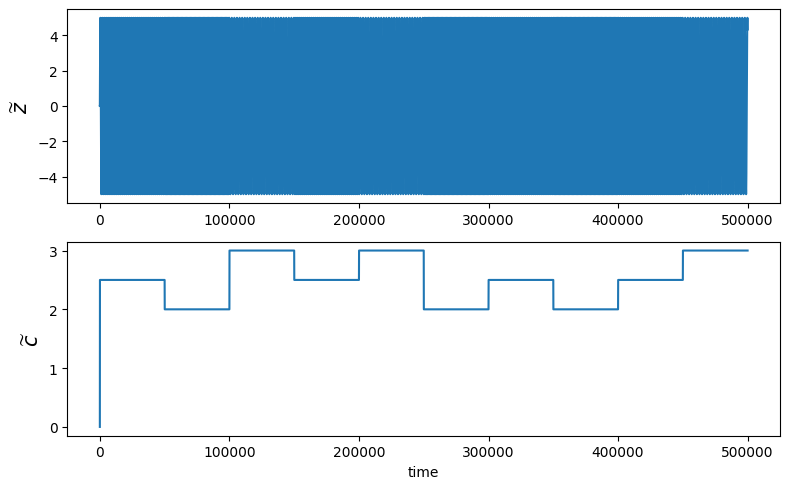

In [6]:
plt.figure(figsize=(8, 5))

plt.subplot(211)
plt.plot(tars_pretrain[0][0])
plt.ylabel("$\widetilde{z}$", fontsize=15)

plt.subplot(212)
plt.plot(tars_pretrain[1][0])
plt.xlabel("time")
plt.ylabel("$\widetilde{c}$", fontsize=15)

plt.tight_layout()
plt.show()

# 创建网络

In [7]:
net = rnn(N, N_z, N_c).to(device=device)

# 预训练

In [8]:
phase = "pretraining"
z_tilde = torch.from_numpy(tars_pretrain[0]).to(device=device)
c_tilde = torch.from_numpy(tars_pretrain[1]).to(device=device)
z_pre_save = [net.z.cpu().numpy().copy()]
c_pre_save = [net.c.cpu().numpy().copy()]
eps_pre_save = [net.eps.cpu().numpy().copy()]
steps = int(t_wlearn/dt)         # 运行出次数
for step in range(steps):
    net(z_tilde[:, step], c_tilde[:, step], step, phase=phase)
    z_pre_save.append(net.z.cpu().numpy().copy())
    c_pre_save.append(net.c.cpu().numpy().copy())
    eps_pre_save.append(net.eps.cpu().numpy().copy())


Text(0, 0.5, 'Context')

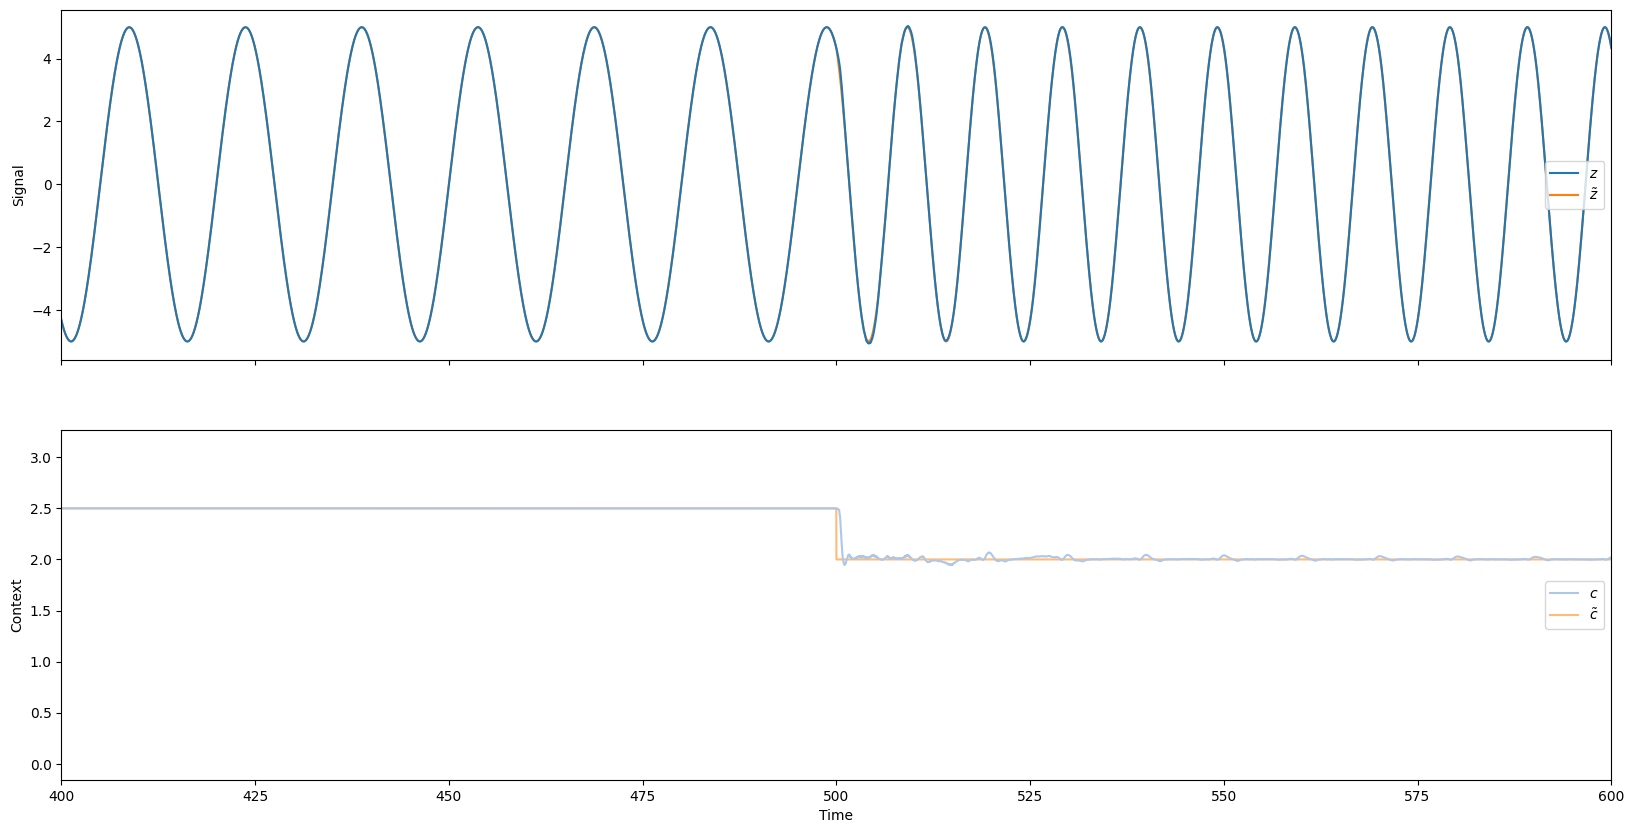

In [9]:
cmap = plt.get_cmap('tab20')

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True)  # , figsize=(20,7)
pretrain_times = np.linspace(0, t_wlearn, int(t_wlearn/dt)+1)

axs[0].plot(pretrain_times, z_pre_save, label='$z$', c=cmap(0), zorder=1)
axs[0].plot(pretrain_times, tars_pretrain[0][0], label=r'$\tilde{z}$', c=cmap(2), zorder=0)
axs[0].legend(loc='right').set_zorder(100)
# axs[0].set_xlim(0, 3 * t_stay)
axs[0].set_xlim(400, 600)
axs[0].set_ylabel('Signal')

axs[1].plot(pretrain_times, c_pre_save, label='$c$', c=cmap(1), zorder=1)
axs[1].plot(pretrain_times, tars_pretrain[1][0], label=r'$\tilde{c}$', c=cmap(3), zorder=0)
axs[1].legend(loc='right').set_zorder(100)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Context')

# 学习目标

In [38]:
# 学习数据
learn_targets_list = np.array([18.5])   # 12.5
T_learn = targets(t_learn, t_learn, learn_targets_list)
tars_learn = T_learn.return_z_c()

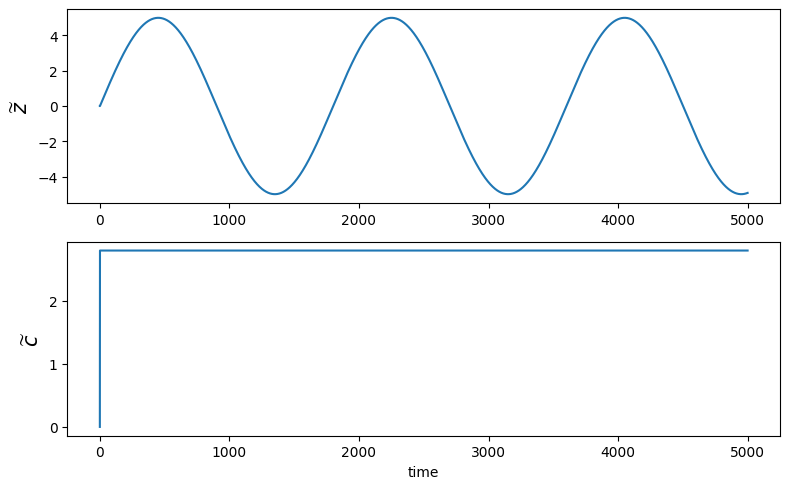

In [39]:
plt.figure(figsize=(8, 5))

plt.subplot(211)
plt.plot(tars_learn[0][0])
plt.ylabel("$\widetilde{z}$", fontsize=15)

plt.subplot(212)
plt.plot(tars_learn[1][0])
plt.xlabel("time")
plt.ylabel("$\widetilde{c}$", fontsize=15)

plt.tight_layout()
plt.show()

In [40]:
phase = "learn"
z_tilde = torch.from_numpy(tars_learn[0]).to(device=device)
c_tilde = torch.from_numpy(tars_learn[1]).to(device=device)
z_learn_save = [net.z.cpu().numpy().copy()]
c_learn_save = [net.c.cpu().numpy().copy()]
eps_learn_save = [net.eps.cpu().numpy().copy()]
steps = int(t_learn/dt)         # 运行出次数
for step in range(steps):
    net(z_tilde[:, step], c_tilde[:, step], step, phase=phase)
    z_learn_save.append(net.z.cpu().numpy().copy())
    c_learn_save.append(net.c.cpu().numpy().copy())
    eps_learn_save.append(net.eps.cpu().numpy().copy())

Text(0, 0.5, 'Context')

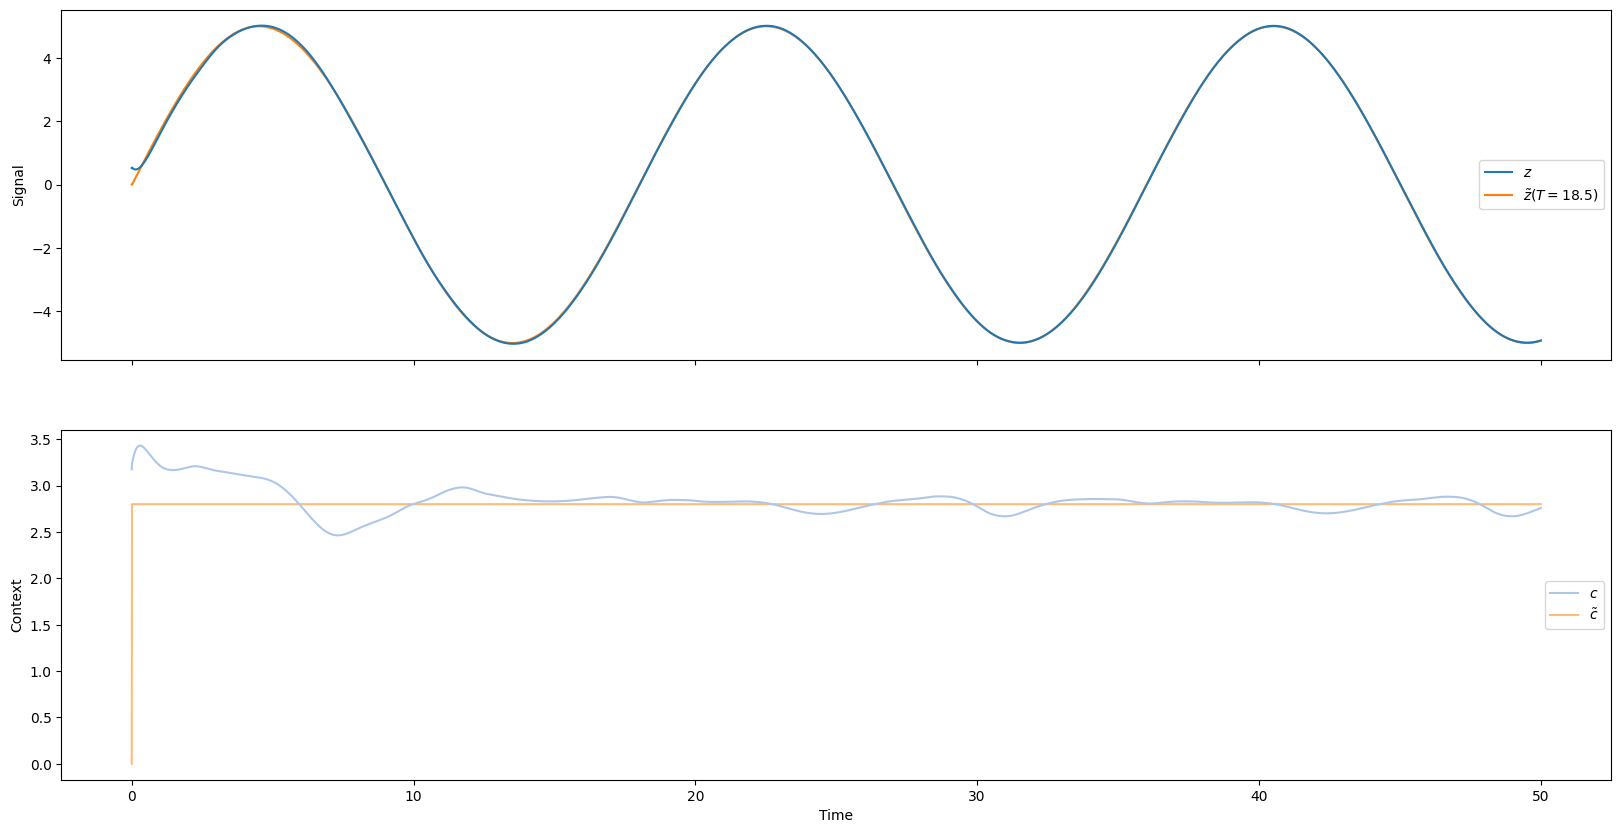

In [41]:
cmap = plt.get_cmap('tab20')

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True)  # , figsize=(20,7)
learn_times = np.linspace(0, t_learn, int(t_learn/dt)+1)

axs[0].plot(learn_times, z_learn_save, label='$z$', c=cmap(0), zorder=1)
axs[0].plot(learn_times, tars_learn[0][0], label=r'$\tilde{{z}}(T={})$'.format(learn_targets_list[0]), c=cmap(2), zorder=0)
axs[0].legend(loc='right').set_zorder(100)
# axs[0].set_xlim(0, 3 * t_stay)
# axs[0].set_xlim(400, 600)
axs[0].set_ylabel('Signal')

axs[1].plot(learn_times, c_learn_save, label='$c$', c=cmap(1), zorder=1)
axs[1].plot(learn_times, tars_learn[1][0], label=r'$\tilde{c}$', c=cmap(3), zorder=0)
axs[1].legend(loc='right').set_zorder(100)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Context')

# 测试结果

In [42]:
# 测试数据（真实）
test_targets_list = learn_targets_list   # 12.5
T_test = targets(t_test, t_test, test_targets_list)
tars_test = T_test.return_z_c()

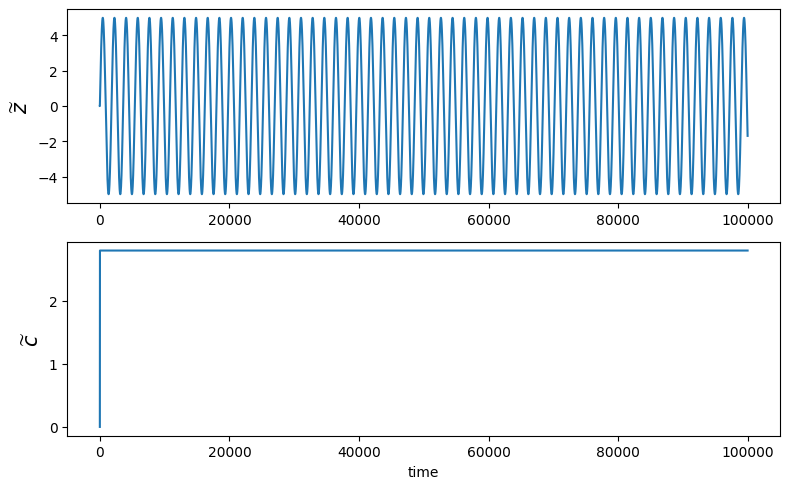

In [43]:
plt.figure(figsize=(8, 5))

plt.subplot(211)
plt.plot(tars_test[0][0])
plt.ylabel("$\widetilde{z}$", fontsize=15)

plt.subplot(212)
plt.plot(tars_test[1][0])
plt.xlabel("time")
plt.ylabel("$\widetilde{c}$", fontsize=15)

plt.tight_layout()
plt.show()

In [44]:
phase = "test"
z_tilde = torch.zeros(N_z, device=device)
c_tilde = torch.zeros(N_c, device=device)
z_test_save = [net.z.cpu().numpy().copy()]
c_test_save = [net.c.cpu().numpy().copy()]
eps_test_save = [net.eps.cpu().numpy().copy()]
steps = int(t_test/dt)         # 运行出次数
for step in range(steps):
    net(z_tilde, c_tilde, step, phase=phase)
    z_test_save.append(net.z.cpu().numpy().copy())
    c_test_save.append(net.c.cpu().numpy().copy())
    eps_test_save.append(net.eps.cpu().numpy().copy())

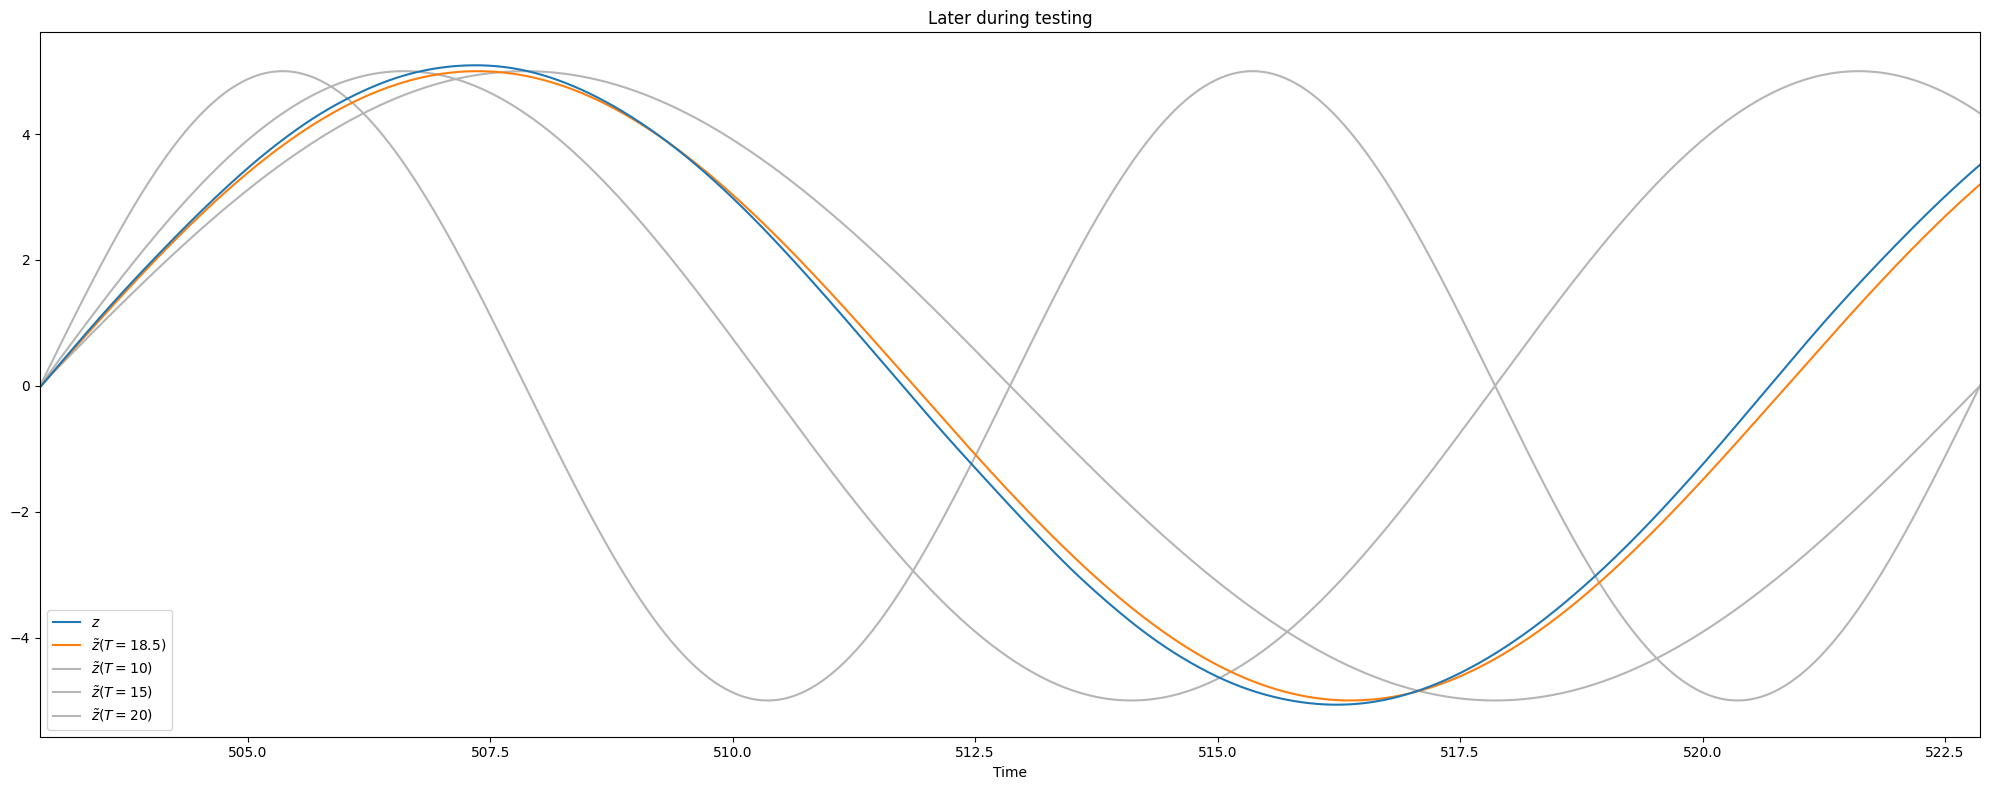

In [50]:
plt.figure(figsize=(20, 8))

test_times = np.linspace(0, t_test, int(t_test/dt)+1)
z_test = z_test_save
c_test = c_test_save
z_tilde_test = tars_test[0][0]
c_tilde_test = tars_test[1][0]
period_learntest = test_targets_list[0]

# # 找出开始的时刻
off = t_test/2
found_start = False
while not found_start:
    z0 = z_test[int(off/dt)]
    z1 = z_test[int(off/dt)+1]
    if abs(z0)<0.05 and z1>z0:
        found_start = True
    else:
        off = off+dt
# t_wlearn
plt.plot(test_times, z_test, label='$z$', c=cmap(0), zorder=2)
plt.plot(test_times + off, z_tilde_test, label=r'$\tilde{{z}}(T={})$'.format(period_learntest), c=cmap(2), zorder=1)
for tar in pretrain_targets_list:
    plt.plot(test_times + off, T_learn.tar_func(tar, test_times)[0], label=r'$\tilde{{z}}(T={})$'.format(tar), c=plt.get_cmap('Greys')(0.4), zorder=0)
plt.xlim(off, off + 2*10)
plt.legend().set_zorder(100)
plt.xlabel('Time')
plt.title('Later during testing')
plt.tight_layout()

In [46]:
pretrain_targets_list

array([10, 15, 20])